In [46]:
import sys
import os
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
import sklearn
import scipy
import matplotlib.pyplot as plt
import itertools
import qinfer as qi
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import PercentFormatter
from matplotlib.patches import Patch


from lfig import LatexFigure

sys.path.append("/home/bf16951/QMD")
import qmla

%matplotlib inline



def get_model_f(mid):
    return q.model_f_scores[mid]



In [139]:
def generation_elo_ratings(es, ax, include_cbar=True):

    ratings = es.ratings_class.ratings_df
    ratings['f_score_a'] = ratings['model_a'].apply(get_model_f)
    ratings['f_score_b'] = ratings['model_b'].apply(get_model_f)
    all_ratings = es.ratings_class.all_ratings
    model_f_scores = q.model_f_scores
    f_score_cmap = es.f_score_cmap

    generations = [int(g) for g in all_ratings.generation.unique()]
    generations = [0]
    num_generations = len(generations)
    gen = 0 

    # TODO : unique linestyle and colour combo for each model ID and tracks across subplots
    all_ratings['Model ID'] = all_ratings['model_id']

    this_gen_ratings = all_ratings[all_ratings.generation==gen]

    colours = {
        m : f_score_cmap(model_f_scores[m])
        for m in this_gen_ratings['model_id']
    }

    sns.lineplot(
        x = 'idx', 
        y = 'rating', 
        hue = r'Model ID', 
        hue_order = sorted(this_gen_ratings.model_id.unique()),
        data=this_gen_ratings, 
        ax = ax,
        legend=False,
        palette = colours, 
#         cbar=include_cbar
    )

    ax.set_ylabel(r"$R_i$", rotation=0, labelpad=10)
    ax.set_xticks([5, 10])
    ax.set_xlabel("Bayes factor comparison", labelpad=5)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)


    inset_ax = inset_axes(
        lf.gridspec_axes[(0,0)], 
#         width=fraction*1.25, 
#         height=fraction*1.25, 
        width=0.6, 
        height=0.6, 
        loc='upper left'
    )

    gene_pool = es.genetic_algorithm.gene_pool
    gene_pool.sort_values('f_score', inplace=True, ascending=False)
    this_gen_genes = gene_pool[gene_pool.generation == 1]
    f_scores = this_gen_genes.f_score
    colours = [f_score_cmap(f) for f in f_scores]
    probabilities = this_gen_genes.probability    

    inset_ax.pie(
        probabilities, 
        colors = colours, 
        radius=1.0,
#         radius=1.0,
        startangle=0, 
        wedgeprops={
            "edgecolor":"k",
            'linewidth': 1, 
            'antialiased': True
        }
    )

    if include_cbar:

        cbar_ax = lf.new_axis(
            force_position = (0,1),
            auto_label=False
        )

        cbar = mpl.colorbar.ColorbarBase(
            cbar_ax, 
            cmap = f_score_cmap,
            orientation="vertical",
            label = r"$F_1$-score",
        )

In [140]:
def gene_pool_progression(gene_pool, ax, draw_cbar=True, cbar_ax=None):
    num_models_per_generation = len(gene_pool[gene_pool.generation == 1])
    num_generations = gene_pool.generation.nunique()
    f_scores_of_gene_pool = np.empty((num_models_per_generation, num_generations))
    for g in gene_pool.generation.unique():

        f_scores_by_gen = gene_pool[
            gene_pool.generation == g
        ].f_score

        f_scores_of_gene_pool[:, g-1] = f_scores_by_gen

    sns.heatmap(
        f_scores_of_gene_pool,
        cmap = f_score_cmap,
        vmin = 0, 
        vmax=1,
        ax = ax,
        cbar=draw_cbar, 
        cbar_kws = dict(
            label=r"$F_1$-score",
            aspect=25, 
            ticks=[0,0.5,1],
        )
    )
    ax.set_yticks([])
    xtick_pos = range(5, num_generations+1, 5)
    ax.set_xticks([g-0.5 for g in xtick_pos])
    ax.set_xticklabels(
        xtick_pos
    )
    ax.set_xlabel('Generation', labelpad=5)

    if cbar_ax is not None:
        cbar = ax.collections[0].colorbar
        cbar.ax.set_ylabel(r"$F_1$", rotation=0, labelpad=10) # if F horizontal
        cbar.ax.yaxis.set_label_position("right", )
        cbar.ax.tick_params(labelleft=True, labelright=False )

# Run analysis

In [141]:
run_path = "Dec_18/20_12"
results_dir = "/home/bf16951/bc_results/"


ga_summary = pd.DataFrame()
unique_chromosomes = pd.DataFrame()

for run_path in ["Dec_17/21_46", "Dec_18/20_12"]:

    run_unique_chromosomes = pd.read_pickle(
        os.path.join(
            "/home/bf16951/bc_results/", 
            run_path,
            'combined_datasets', 
            'unique_chromosomes.p'
        )
    )
    run_ga_summary = pd.read_pickle(
        os.path.join(
            results_dir, run_path, 'combined_datasets', 'gen_alg_summary.p'
    ))
    run_unique_chromosomes["run"] = run_path
    run_ga_summary["run"] = run_path
    
    
    ga_summary = ga_summary.append(
        run_ga_summary, ignore_index=True, 
    )
    unique_chromosomes = unique_chromosomes.append(
        run_unique_chromosomes, ignore_index=True
    )

# 2 random instances to remove so there's exactly 100 reported
drop_indices = np.random.choice(ga_summary.index, 2, replace=False)
removed_instances = ga_summary.iloc[drop_indices][
    ["run", "qmla_id"]
]

ga_summary.drop(drop_indices, inplace=True)

# also remove their chromosomes
for di in drop_indices:
    r = removed_instances.loc[di].run
    qid = removed_instances.loc[di].qmla_id
    
    chromsomes_to_remove = unique_chromosomes[
        (unique_chromosomes.qmla_id == qid)
        & ( unique_chromosomes.run == r)
    ].index
    
    unique_chromosomes.drop(
        chromsomes_to_remove, inplace=True
    )
    
found_terms = qmla.utilities.flatten(list(ga_summary.champ_terms.values))
unique_terms = list(set(found_terms))
term_counts = {a : found_terms.count(a) for a in unique_terms}

non_gene_weight = max(term_counts.values())/10
present_colour = mpl.colors.to_hex(f_score_cmap(0.9)) # colour for true terms
non_present_colour = mpl.colors.to_hex(f_score_cmap(0.1)) #  colour for false positive terms
non_gene_colour = 'k'

true_info = pickle.load(open(
    os.path.join(
        results_dir, 
        run_path,
        'run_info.p'
    ),
    'rb'
))
true_terms = true_info['true_model'].split('+')    

term_occurences = pd.DataFrame()

max_n_qubits = 4
pauli_axes = ['x', 'y', 'z']
avail_qubits = range(1, max_n_qubits+1)

for q1 in avail_qubits:
    for q2 in avail_qubits:
        for p in pauli_axes:
            term = 'pauliSet_{q1}J{q2}_{p}J{p}_d4'.format(
                q1 = q1, 
                q2 = q2, 
                p = p
            )
            try:
                ct = term_counts[term]
                colour = present_colour
                if term not in true_terms: 
#                     ct *= -1
                    colour = non_present_colour
            except:
                ct = 0
            if q1>=q2: 
                colour = non_gene_colour
                ct = non_gene_weight
                
            if q2 > 1 and q1 < max_n_qubits:
                this_term = pd.Series({
                    'p' : p , 
                    'q1' : q1, 
                    'q2' : q2, 
                    'count' : ct,
                    'colour' : colour
                })
                term_occurences = term_occurences.append(
                    this_term, 
                    ignore_index = True
                )
            
term_types = list(itertools.product(avail_qubits[1:], pauli_axes))

piv = term_occurences.pivot_table(
    columns='q1', 
    index = ['q2', 'p'],
    values='count'
)
terms_matrix = np.matrix(piv)

colours_matrix = np.matrix(term_occurences.pivot_table(
    columns='q1',
    index=['q2', 'p'],
    values='colour', 
    aggfunc=lambda x: ''.join(str(v) for v in x)
))


In [142]:
# Hinton diagram

def terms_hinton(ax, matrix, colours_matrix):
    max_weight = None
    if not max_weight:
        max_weight = 2 ** np.ceil(np.log(np.abs(matrix).max()) / np.log(2))

#     ax.set_aspect('equal', 'box')

    for (x, y), w in np.ndenumerate(matrix):
    #     color = present_colour if w > 0 else non_present_colour
        color = colours_matrix[x, y]

        size = np.sqrt( np.abs(w) / max_weight)
        # normalise size so they appear as squares
        size = np.sqrt(np.abs(w) / max_weight)
        size *= 0.618
        size_x = size
        size_y = 1.618*size
        rect = plt.Rectangle(
            [x - size_x / 2, y - size_y / 2], 
            size_x, 
            size_y,
            facecolor=color, 
            edgecolor=color
        )

        if color == non_gene_colour:
            nsizex = 0.35
            nsizey = 1.618*nsizex
            
            rect = plt.Rectangle(
                [x - nsizex/2, 
                 y - nsizey/2], 
                nsizex, 
                nsizey,
                facecolor=color, 
                edgecolor=color
            )


        ax.add_patch(rect)

    ax.autoscale_view()
    ax.invert_yaxis()
    ax.set_xticks(range(-1, matrix.shape[0]))
    # xlabels = [r"${p}_{{{q}}}$".format(q=t[1], p=t[0]) for t in term_types]
    # xlabels = [r"${p}/{q}$".format(q=t[1], p=t[0]) for t in term_types]
    xlabels = [r"$ \hat{{\sigma}}_{{i,{p}}}^{{{q}}}$".format(q=t[1], p=t[0]) for t in term_types]
    xlabels.insert(0, '')
    ax.set_xticklabels(xlabels)
    ax.set_yticks(range(matrix.shape[1]))
    ax.set_ylabel('Qubit, i', labelpad=10)
    ax.set_xlabel('Coupling qubit/axis', labelpad=10)

    ax.set_yticks(
        range(matrix.shape[1]), 
    )
    ax.set_yticklabels(
        list(range(1, 1+matrix.shape[1]))
    )
    ax.tick_params(axis=u'both', which=u'both',length=0, pad=10)


    legend_elements = [
        Patch(
            facecolor=present_colour, 
            label=r"$\in \mathcal{T}_0$",
            linewidth=10,
        ),
        Patch(
            facecolor=non_present_colour, 
            label=r"$\notin \mathcal{T}_0$",
            linewidth=5,
        ),
        Patch(
            facecolor=non_gene_colour, 
            label=r"$\notin \mathcal{T}$",
            linewidth=20,
        ),
    ]

    
    colors = [present_colour, non_present_colour, non_gene_colour]
    patches = [ plt.plot([],[], marker="s", ms=5, ls="", mec=None, color=colors[i], 
                label="{:s}".format(texts[i]) )[0]  for i in range(len(texts)) ]    
    
    ax.legend(
        handles = patches, 
        ncol=len(legend_elements), 
        loc='lower center',
        handletextpad = 0.1, 
        columnspacing = 0.5, 
    )

    ylim = ax.get_ylim()
    ax.set_ylim(
        matrix.shape[1] + 1, 
        ylim[1] - 0.25
    )
    for x in range(matrix.shape[1]):
        ax.axhline(x, color='grey', lw=0.5, )
    for y in range(matrix.shape[0]):
        ax.axvline(y, color='grey', lw=0.5)

# Plot all together

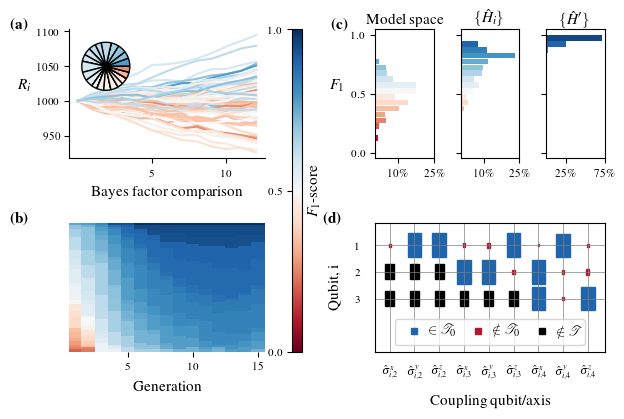

In [152]:
save_directory = "/home/bf16951/thesis/theoretical_study/figures"


fraction = 1.0
lf = LatexFigure(
    fraction=fraction, 
    use_gridspec=True, 
    gridspec_layout=(2, 6),
    gridspec_params={
        'width_ratios' : [1, 0.05, 0.1, 0.3, 0.3, 0.3],
        'wspace' : 0.4, 
        'hspace' : 0.5, 
    },
    auto_label=False
)

cbar_ax = lf.new_axis(
    force_position = (0,1),
    span = ('all', 1),
    auto_label=False
)

cbar = mpl.colorbar.ColorbarBase(
    cbar_ax, 
    cmap = f_score_cmap,
    orientation="vertical",
    label = r"$F_1$-score",
    ticks = [0, 0.5, 1.0]
)
cbar_ax.yaxis.set_ticks_position('left')
cbar_ax.yaxis.set_label_position('right')


# Single generation
run_path = "Dec_10/14_40"
results = qmla.load_results(
    results_folder = "/home/bf16951/bc_results/",
    results_time = run_path,
    instance_id=1, 
)
q = results['qmla_instance']
es = results['exploration_strategy']

ax = lf.new_axis(
    force_position=(0,0),
    label_position = (-0.3, 1.0),
    label="a"
)
generation_elo_ratings(
    es, 
    ax,
    include_cbar=False
)

# Single instance
run_path = "Dec_10/16_12"
results = qmla.load_results(
    results_folder = "/home/bf16951/bc_results/",
    results_time = run_path,
)
q = results['qmla_instance']
es = results['exploration_strategy']
storage = results['storage']

gene_pool = es.genetic_algorithm.gene_pool
gene_pool.sort_values('f_score', inplace=True, ascending=False)
model_f_scores = q.model_f_scores
f_score_cmap = es.f_score_cmap

ax = lf.new_axis(
    label="b", 
    force_position=(1,0),
    label_position = (-0.3, 1.0)
)
gene_pool_progression(gene_pool, ax, draw_cbar=False)



fscore_cmap = mpl.cm.RdBu # q.growth_class.f_score_cmap
f_score_bins = list(np.arange(0, 1.01, 0.05))
bin_colours = [fscore_cmap(b) for b in f_score_bins] # or set to fixed colour for all

sampled_f_scores = pickle.load(open('sampled_f_scores.p', 'rb'))  
regenerate_f_samples = False
if regenerate_f_samples:
    # sampled_f_scores = [rand_model_f(true_chromosome, n_terms) for _ in range(int(n_runs))]
    sampled_f_scores = [
        rand_model_f(true_chromosome, n_terms, i) 
        for i in range(2**n_terms - 1)
    ] # checking every model since

    pickle.dump(
        sampled_f_scores, 
        open(
            'sampled_f_scores.p', 
            'wb'
        )
    )


# Model space
bar_plot_leftmost_ax = 3
ax = lf.new_axis(
    force_position = (0, bar_plot_leftmost_ax),
    label="c",
    label_position=(-0.75, 1.0),
)
hist, bin_edges = np.histogram(
    sampled_f_scores, 
    bins = f_score_bins, 
    weights=np.ones(len(sampled_f_scores)) / len(sampled_f_scores),
)
ax.barh(
    bin_edges[:-1], 
    hist, 
    align='edge', 
    height=1/len(bin_edges),
    color=bin_colours,
)
fticks = [0, 0.25, 0.5, 0.75,  1]
fticks = [0, 0.5, 1]
ax.set_yticks(fticks)
ax.set_ylabel(r"$F_{1}$", rotation=360, labelpad=10)
ax.set_xticks([0.1, 0.25,])
ax.xaxis.set_major_formatter(PercentFormatter(1, decimals=0))
ax.set_xlabel("Model space", )
ax.xaxis.set_label_position('top')

# QMLA found models
ax = lf.new_axis(
    force_position = (0, bar_plot_leftmost_ax+1)
)
generated_f_scores = list(unique_chromosomes.f_score.values)

hist, bin_edges = np.histogram(
    generated_f_scores,
    bins = f_score_bins,
    weights=np.ones(len(generated_f_scores)) / len(generated_f_scores),
)
ax.barh(
    bin_edges[:-1], 
    hist, 
    align='edge', 
    height=1/len(bin_edges),
    color=bin_colours,
)

ax.set_yticks(fticks)
ax.tick_params(
    labelleft=False
)
ax.set_ylabel('')
ax.xaxis.set_major_formatter(PercentFormatter(1, decimals=0))
ax.set_xticks([0.1, 0.25,])
ax.set_xlabel(r"$\{\hat{H}_i\}$")
ax.xaxis.set_label_position('top')

# Champion models
ax = lf.new_axis(
    force_position = (0,bar_plot_leftmost_ax+2),
)
f_scores = ga_summary['champ_f_score']

hist, bin_edges = np.histogram(
    f_scores,
    bins = f_score_bins,
    weights=np.ones(len(f_scores)) / len(f_scores),
)

ax.barh(
    bin_edges[:-1], 
    hist, 
    align='edge', 
    height=1/len(bin_edges),
    color=bin_colours,
)

ax.set_yticks(fticks)
ax.tick_params(
    labelleft=False
)
ax.set_ylabel('')

ax.set_xticks([0.25, 0.75])
ax.xaxis.set_major_formatter(PercentFormatter(1, decimals=0))
ax.set_xlabel(r"$\{ \hat{H}^{\prime} \}$")
ax.xaxis.set_label_position('top')


ax = lf.new_axis(
    force_position = (1, bar_plot_leftmost_ax),
    label="d",
    label_position=(-0.225, 1.0),
    span=(1,3)
)
terms_hinton(ax, terms_matrix, colours_matrix)

In [153]:
lf.save(os.path.abspath(os.path.join("..", "content", "figures", "genetic_algorithm_analysis.pdf") ))

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


In [154]:
terms_matrix

matrix([[  2.,  10.,  10.],
        [100.,  10.,  10.],
        [100.,  10.,  10.],
        [  3., 100.,  10.],
        [  5., 100.,  10.],
        [100.,   4.,  10.],
        [  1., 100., 100.],
        [ 95.,   4.,   1.],
        [  2.,   5., 100.]])